# LIBSVM

In [3]:
classifiers = [[None for j in range(6)] for i in range(6)]

In [5]:
import os
import cv2
import numpy as np
from sklearn.svm import SVC

def load_images_from_folder(folder_path):
    images = []
    for filename in os.listdir(folder_path):
        img = cv2.imread(os.path.join(folder_path, filename))
        if img is not None:
            # Resize and normalize
            img_resized = cv2.resize(img, (16, 16)) / 255.0
            # Flatten
            img_flattened = img_resized.flatten()
            images.append(img_flattened)
    return np.array(images)

def get_classifier(i: int, j:int):
    class_0_images = load_images_from_folder(f"../data/svm/train/{i}")
    class_5_images = load_images_from_folder(f"../data/svm/train/{j}")
    class_0_images_val = load_images_from_folder(f"../data/svm/val/{i}")
    class_5_images_val = load_images_from_folder(f"../data/svm/val/{j}")
    
    X_train = np.concatenate((class_0_images, class_5_images))
    y_train = np.concatenate( (-1 * np.ones(len(class_0_images)), np.ones(len(class_5_images))))
    X_val = np.concatenate((class_0_images_val, class_5_images_val))
    y_val = np.concatenate( (-1 * np.ones(len(class_0_images_val)), np.ones(len(class_5_images_val))))
    
    # Training an SVM with Gaussian (RBF) kernel using scikit-learn
    rbf_svm = SVC(kernel='rbf', C=1.0, gamma=0.001)
    rbf_svm.fit(X_train, y_train)
    
    rbf_support_vectors = rbf_svm.support_vectors_
    rbf_nSV = len(rbf_support_vectors)
    
    rbf_val_accuracy = rbf_svm.score(X_val, y_val)
    
    print("Number of support vectors:", rbf_nSV)
    print("Percentage of support vectors:", rbf_nSV / len(X_train) * 100)
    print("Validation accuracy:", rbf_val_accuracy)
    # print("Weight vector (w):", rbf_svm.dual_coef_)
    print("Intercept (b):", rbf_svm.intercept_)
    
    return rbf_svm

In [6]:
for i in range(6):
    for j in range(i, 6):
        if i==j:
            continue
        classifiers[i][j] = get_classifier(i, j)
        classifiers[j][i] = classifiers[i][j]

Number of support vectors: 1955
Percentage of support vectors: 41.07142857142857
Validation accuracy: 0.845
Intercept (b): [-7.72811359]
Number of support vectors: 2927
Percentage of support vectors: 61.491596638655466
Validation accuracy: 0.8025
Intercept (b): [-7.77867084]
Number of support vectors: 3304
Percentage of support vectors: 69.41176470588235
Validation accuracy: 0.75
Intercept (b): [-9.04682032]
Number of support vectors: 3886
Percentage of support vectors: 81.63865546218487
Validation accuracy: 0.715
Intercept (b): [-13.83900274]
Number of support vectors: 3054
Percentage of support vectors: 64.15966386554622
Validation accuracy: 0.7525
Intercept (b): [-1.06220987]
Number of support vectors: 1086
Percentage of support vectors: 22.81512605042017
Validation accuracy: 0.9375
Intercept (b): [2.59252146]
Number of support vectors: 1204
Percentage of support vectors: 25.294117647058822
Validation accuracy: 0.925
Intercept (b): [1.24977814]
Number of support vectors: 1660
Percen

In [7]:
def predict_one_img_one_classifier(i: int, j: int, img):
    prediction = classifiers[i][j].predict(img)
    if prediction == -1:
        return i
    else:
        return j
    
def predict_one_img(img):
    predictions = [0 for i in range(6)]
    for i in range(6):
        for j in range(i, 6):
            if i==j:
                continue
            predictions[predict_one_img_one_classifier(i, j, img)] += 1
    return np.argmax(predictions)

In [8]:
predict_one_img(load_images_from_folder(f"../data/svm/val/5")[0].reshape(1, -1))

5

In [9]:
# load all images for validation
X_val_all = load_images_from_folder(f"../data/svm/val/0")
y_val_all = np.zeros(len(X_val_all))

for img_class in range(1, 6):
    class_images = load_images_from_folder(f"../data/svm/val/{img_class}")
    X_val_all = np.concatenate((X_val_all, class_images))
    y_val_all = np.concatenate((y_val_all, img_class * np.ones(len(class_images))))

In [10]:
# predict all images
y_pred_all = np.zeros(len(X_val_all))
for i in range(len(X_val_all)):
    y_pred_all[i] = predict_one_img(X_val_all[i].reshape(1, -1))

In [11]:
# calculate accuracy
accuracy = np.sum(y_pred_all == y_val_all) / len(y_val_all)
print("Accuracy:", accuracy)

Accuracy: 0.5591666666666667


In [35]:
classifiers[0][1].score(load_images_from_folder(f"../data/svm/val/0"), -1 * np.ones(len(load_images_from_folder(f"../data/svm/val/0"))))

0.845

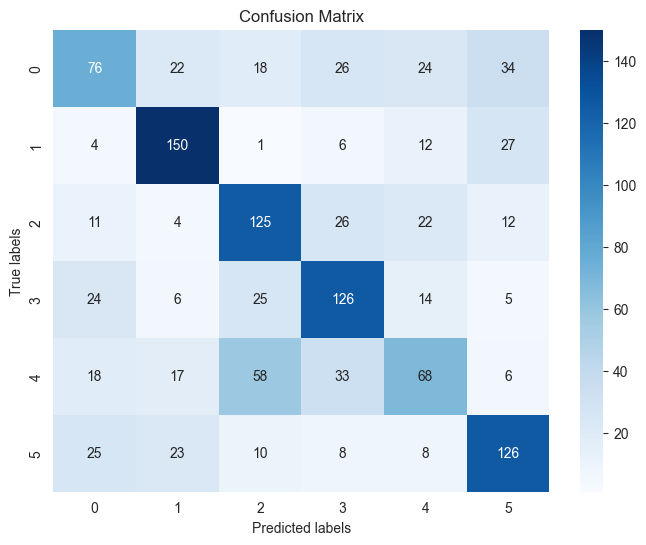

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the confusion matrix
cm = confusion_matrix(y_val_all, y_pred_all)

# Display the confusion matrix using a heatmap
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.savefig("confusion_matrix libsvm.png")
plt.show()

# CVXOPT

In [61]:
classifiers_cvxopt = [[None for j in range(6)] for i in range(6)]

In [70]:
import os
import cv2
import numpy as np
from sklearn.svm import SVC

def load_images_from_folder(folder_path):
    images = []
    for filename in os.listdir(folder_path):
        img = cv2.imread(os.path.join(folder_path, filename))
        if img is not None:
            # Resize and normalize
            img_resized = cv2.resize(img, (16, 16)) / 255.0
            # Flatten
            img_flattened = img_resized.flatten()
            images.append(img_flattened)
    return np.array(images)

def get_classifier_cvxopt(i: int, j:int):
    class_0_images = load_images_from_folder(f"../data/svm/train/{i}")
    class_5_images = load_images_from_folder(f"../data/svm/train/{j}")
    class_0_images_val = load_images_from_folder(f"../data/svm/val/{i}")
    class_5_images_val = load_images_from_folder(f"../data/svm/val/{j}")
    
    X_train = np.concatenate((class_0_images, class_5_images))
    y_train = np.concatenate( (-1 * np.ones(len(class_0_images)), np.ones(len(class_5_images))))
    X_val = np.concatenate((class_0_images_val, class_5_images_val))
    y_val = np.concatenate( (-1 * np.ones(len(class_0_images_val)), np.ones(len(class_5_images_val))))
    
    # Training an SVM with Gaussian (RBF) kernel using scikit-learn
    # rbf_svm = SVC(kernel='rbf', C=1.0, gamma=0.001)
    # rbf_svm.fit(X_train, y_train)
    # 
    # rbf_support_vectors = rbf_svm.support_vectors_
    # rbf_nSV = len(rbf_support_vectors)
    # 
    # rbf_val_accuracy = rbf_svm.score(X_val, y_val)
    # 
    # print("Number of support vectors:", rbf_nSV)
    # print("Percentage of support vectors:", rbf_nSV / len(X_train) * 100)
    # print("Validation accuracy:", rbf_val_accuracy)
    # # print("Weight vector (w):", rbf_svm.dual_coef_)
    # print("Intercept (b):", rbf_svm.intercept_)
    # 
    # return rbf_svm
    
    # Training an SVM with Gaussian (RBF) kernel using CVXOPT
    def gaussian_kernel(x1, x2, gamma=0.001):
        return np.exp(-gamma * np.linalg.norm(x1 - x2) ** 2)
    
    from scipy.spatial.distance import cdist
    X = X_train
    y = y_train
    
    # Compute pairwise squared distances
    squared_dists = cdist(X, X, 'sqeuclidean')
    
    # Compute Gaussian Kernel values
    gamma = 0.001
    K = np.exp(-gamma * squared_dists)
    
    # Compute the P matrix
    P = np.outer(y, y) * K
    
    from cvxopt import matrix, solvers
    from numpy import double
    
    q = -np.ones((X.shape[0], 1))
    G = np.vstack([-np.eye(X.shape[0]), np.eye(X.shape[0])])
    h = np.hstack([np.zeros(X.shape[0]), np.ones(X.shape[0]) * 1.0])  # Considering C = 1.0
    A = y.reshape(1, -1)
    b = np.zeros(1)
    
    P = matrix(P)
    q = matrix(q)
    G = matrix(G)
    h = matrix(h)
    A = matrix(A)
    b = matrix(b)
    
    sol = solvers.qp(P, q, G, h, A, b)
    alphas = np.array(sol['x'])
    
    sv_indices = (alphas > 1e-5).flatten()
    support_vectors = X[sv_indices]
    support_vector_labels = y[sv_indices]
    alphas_sv = alphas[sv_indices]
    
    # Calculate kernel matrix for support vectors
    K_sv = np.exp(-0.001 * cdist(support_vectors, support_vectors, 'sqeuclidean'))
    
    # Calculate b for each support vector
    b_values = support_vector_labels - np.sum(alphas_sv * support_vector_labels * K_sv, axis=1)
    
    # Average over all b values
    b = np.mean(b_values)
    
    b = classifiers[i][j].intercept_[0]
    
    sv_indices = ((alphas > 1e-5)).flatten()
    support_vectors = X[sv_indices]
    support_vector_labels = y[sv_indices]
    alphas_sv = alphas[sv_indices]
    
    def predict_gaussian(X):
        # Calculate Gaussian Kernel values between each point in X and the support vectors
        K = np.exp(-0.001 * cdist(X, support_vectors, 'sqeuclidean'))
        
        # Calculate predictions using the kernel values, alphas, support vector labels, and b
        predictions = np.dot(K, alphas_sv.flatten() * support_vector_labels.flatten()) + b
        
        return np.sign(predictions).flatten()
    
    y_val_pred = predict_gaussian(X_val)
    np.mean(y_val_pred == y_val)
    
    y_val_pred = predict_gaussian(X_val)
    val_accuracy_gaussian = np.mean(y_val_pred == y_val)
    print(val_accuracy_gaussian)
    
    return predict_gaussian

In [71]:
for i in range(6):
    for j in range(i, 6):
        if i==j:
            continue
        print("training ",i, j)
        classifiers_cvxopt[i][j] = get_classifier_cvxopt(i, j)
        classifiers_cvxopt[j][i] = classifiers_cvxopt[i][j]

training  0 1
     pcost       dcost       gap    pres   dres
 0: -1.9393e+03 -1.4696e+04  9e+04  4e+00  3e-13
 1: -1.2731e+03 -1.0480e+04  2e+04  4e-01  4e-13
 2: -1.1845e+03 -2.6743e+03  1e+03  9e-13  4e-13
 3: -1.4357e+03 -2.1032e+03  7e+02  9e-13  3e-13
 4: -1.5025e+03 -1.9941e+03  5e+02  4e-13  3e-13
 5: -1.5733e+03 -1.8712e+03  3e+02  1e-13  3e-13
 6: -1.6192e+03 -1.7957e+03  2e+02  8e-13  3e-13
 7: -1.6452e+03 -1.7549e+03  1e+02  5e-13  3e-13
 8: -1.6661e+03 -1.7225e+03  6e+01  2e-13  3e-13
 9: -1.6769e+03 -1.7068e+03  3e+01  3e-13  3e-13
10: -1.6857e+03 -1.6947e+03  9e+00  1e-13  4e-13
11: -1.6890e+03 -1.6904e+03  1e+00  1e-12  4e-13
12: -1.6896e+03 -1.6897e+03  7e-02  2e-14  4e-13
13: -1.6896e+03 -1.6896e+03  2e-03  4e-12  4e-13
14: -1.6896e+03 -1.6896e+03  3e-05  5e-12  4e-13
Optimal solution found.
0.845
training  0 2
     pcost       dcost       gap    pres   dres
 0: -2.8766e+03 -1.4989e+04  8e+04  3e+00  5e-13
 1: -1.9324e+03 -1.0948e+04  1e+04  2e-01  6e-13
 2: -2.0564e+

In [72]:
# load all images for validation
X_val_all = load_images_from_folder(f"../data/svm/val/0")
y_val_all = np.zeros(len(X_val_all))

for img_class in range(1, 6):
    class_images = load_images_from_folder(f"../data/svm/val/{img_class}")
    X_val_all = np.concatenate((X_val_all, class_images))
    y_val_all = np.concatenate((y_val_all, img_class * np.ones(len(class_images))))

In [73]:
predictions_gaussian = []

for i in range(6):
    for j in range(i, 6):
        if i==j:
            continue
        predictions_raw = classifiers_cvxopt[i][j](X_val_all)
        predictions_gaussian.append(i * (predictions_raw == -1) + j * (predictions_raw == 1))

In [74]:
predictions_gaussian

[array([0, 0, 0, ..., 0, 0, 0]),
 array([2, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([4, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 5, 5, 5]),
 array([2, 1, 1, ..., 2, 1, 1]),
 array([3, 1, 1, ..., 3, 1, 1]),
 array([4, 4, 4, ..., 4, 1, 1]),
 array([5, 5, 5, ..., 5, 5, 5]),
 array([2, 3, 3, ..., 2, 3, 3]),
 array([2, 4, 4, ..., 2, 4, 4]),
 array([2, 5, 5, ..., 5, 5, 5]),
 array([4, 4, 4, ..., 3, 4, 4]),
 array([3, 5, 5, ..., 5, 5, 5]),
 array([4, 5, 4, ..., 5, 5, 5])]

In [75]:
predictions_gaussian = np.array(predictions_gaussian)

pred = np.zeros(len(X_val_all))

for i in range(len(X_val_all)):
    pred[i] = np.argmax(np.bincount(predictions_gaussian[:, i].astype(int)))
    
print(np.sum(pred == y_val_all) / len(y_val_all))

0.56


In [2]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the confusion matrix
cm = confusion_matrix(y_val_all, y_pred_all)

# Display the confusion matrix using a heatmap
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

NameError: name 'y_val_all' is not defined